In [282]:
import pandas

pandas.set_option('display.max_columns', None)
pandas.set_option('display.max_rows', 25)

# Setting up the environment

The next couple cells define global variables used throughout the notebook and ingest the training data that will be used to build a data model.

In [283]:
import os

# Set up some variables for the training data paths
BASE_DATA_PATH = os.path.join('..', 'data')
TRAIN_DATA_PATH = os.path.join(BASE_DATA_PATH, 'train')

TRAINING_PROVIDERS_PATH = os.path.join(TRAIN_DATA_PATH, 'Train-1542865627584.csv')
TRAINING_INPATIENT_PATH = os.path.join(TRAIN_DATA_PATH, 
    'Train_Inpatientdata-1542865627584.csv')
TRAINING_OUTPATIENT_PATH = os.path.join(TRAIN_DATA_PATH, 
    'Train_Outpatientdata-1542865627584.csv')
TRAINING_BENEFICIARY_PATH = os.path.join(TRAIN_DATA_PATH, 
    'Train_Beneficiarydata-1542865627584.csv')

# Defines the default behavior for responding to values that do not exist in data set
DEFAULT_NA_VALUE = "None"


In [284]:
# Read all of the training data
train_providers = pandas.read_csv(TRAINING_PROVIDERS_PATH)
train_inpatient = pandas.read_csv(TRAINING_INPATIENT_PATH)
train_outpatient = pandas.read_csv(TRAINING_OUTPATIENT_PATH)
train_beneficiary = pandas.read_csv(TRAINING_BENEFICIARY_PATH)

In [285]:
# How similar are the inpatient/outpatient data? Let's see how many columns are
# unique between the two data sets
inp_unique_cols = [x for x in train_inpatient.columns if x not in train_outpatient.columns]
print(f'Unique columns in inpatient: {inp_unique_cols}')

outp_unique_cols = [x for x in train_outpatient.columns if x not in train_inpatient.columns]
print(f'Unique columns in outpatient: {outp_unique_cols}')

Unique columns in inpatient: ['AdmissionDt', 'DischargeDt', 'DiagnosisGroupCode']
Unique columns in outpatient: []


# Merging claim data sets

Based on what we know about the columns in the inpatient/outpatient tables, we can safely merge those datasets with minimal disruption. Recommend combining all of the claims into a single dataframe that has all of the data from each table with the following columns added:
- Additional column for inpatient vs outpatient flag
- Columns unique to inpatient (i.e., AdmissionDt, DischargeDt, DiagnosisGroupCode)

In [286]:
# Add a flag to each of the data sets to indicate whether they came from the
# inpatient vs. outpatient frames
train_inpatient['In/Out'] = 'In'
train_outpatient['In/Out'] = 'Out'

# Use the concat operation to create a union of the two data sets. This 
# automatically handles any missing columns between the two sets, so no need
# to manually add missing columns to the outpatient data first.
train_claims = pandas.concat([train_inpatient, train_outpatient], ignore_index=True)

train_claims

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,AdmissionDt,ClmAdmitDiagnosisCode,DeductibleAmtPaid,DischargeDt,DiagnosisGroupCode,ClmDiagnosisCode_1,ClmDiagnosisCode_2,ClmDiagnosisCode_3,ClmDiagnosisCode_4,ClmDiagnosisCode_5,ClmDiagnosisCode_6,ClmDiagnosisCode_7,ClmDiagnosisCode_8,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6,In/Out
0,BENE11001,CLM46614,2009-04-12,2009-04-18,PRV55912,26000,PHY390922,NaN,NaN,2009-04-12,7866,1068.0,2009-04-18,201,1970,4019,5853,7843,2768,71590,2724,19889,5849,NaN,NaN,NaN,NaN,NaN,NaN,NaN,In
1,BENE11001,CLM66048,2009-08-31,2009-09-02,PRV55907,5000,PHY318495,PHY318495,NaN,2009-08-31,6186,1068.0,2009-09-02,750,6186,2948,56400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7092.0,NaN,NaN,NaN,NaN,NaN,In
2,BENE11001,CLM68358,2009-09-17,2009-09-20,PRV56046,5000,PHY372395,NaN,PHY324689,2009-09-17,29590,1068.0,2009-09-20,883,29623,30390,71690,34590,V1581,32723,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,In
3,BENE11011,CLM38412,2009-02-14,2009-02-22,PRV52405,5000,PHY369659,PHY392961,PHY349768,2009-02-14,431,1068.0,2009-02-22,067,43491,2762,7843,32723,V1041,4254,25062,40390,4019,NaN,331.0,NaN,NaN,NaN,NaN,NaN,In
4,BENE11014,CLM63689,2009-08-13,2009-08-30,PRV56614,10000,PHY379376,PHY398258,NaN,2009-08-13,78321,1068.0,2009-08-30,975,042,3051,34400,5856,42732,486,5119,29620,20300,NaN,3893.0,NaN,NaN,NaN,NaN,NaN,In
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
558206,BENE159198,CLM510792,2009-08-06,2009-08-06,PRV53699,800,PHY364188,PHY364188,PHY385752,NaN,NaN,0.0,NaN,NaN,2163,V4575,53190,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Out
558207,BENE159198,CLM551294,2009-08-29,2009-08-29,PRV53702,400,PHY423019,PHY332284,NaN,NaN,NaN,0.0,NaN,NaN,07041,5781,25000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Out
558208,BENE159198,CLM596444,2009-09-24,2009-09-24,PRV53676,60,PHY361063,NaN,NaN,NaN,NaN,0.0,NaN,NaN,V570,78079,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Out
558209,BENE159198,CLM636992,2009-10-18,2009-10-18,PRV53689,70,PHY403198,NaN,PHY419379,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Out


# Merging patients with claims

Using the beneficiary column in the claim data, we can also populate details about the patient in each of the transactions.

This potentially allows us to engineer some additional features that are specific to beneficiaries across transactions. For example, how long has it been since a beneficiary's last claim?

In [287]:
# Do a left outer join in case there are any claims that don't have any corresponding beneficiaries
# defined in the beneficiary data set
train_claims = train_claims.merge(train_beneficiary, how='left', on='BeneID')

# TODO: Are there any claims that don't have corresponding beneficiary definitions?

train_claims

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,AdmissionDt,ClmAdmitDiagnosisCode,DeductibleAmtPaid,DischargeDt,DiagnosisGroupCode,ClmDiagnosisCode_1,ClmDiagnosisCode_2,ClmDiagnosisCode_3,ClmDiagnosisCode_4,ClmDiagnosisCode_5,ClmDiagnosisCode_6,ClmDiagnosisCode_7,ClmDiagnosisCode_8,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6,In/Out,DOB,DOD,Gender,Race,RenalDiseaseIndicator,State,County,NoOfMonths_PartACov,NoOfMonths_PartBCov,ChronicCond_Alzheimer,ChronicCond_Heartfailure,ChronicCond_KidneyDisease,ChronicCond_Cancer,ChronicCond_ObstrPulmonary,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt
0,BENE11001,CLM46614,2009-04-12,2009-04-18,PRV55912,26000,PHY390922,NaN,NaN,2009-04-12,7866,1068.0,2009-04-18,201,1970,4019,5853,7843,2768,71590,2724,19889,5849,NaN,NaN,NaN,NaN,NaN,NaN,NaN,In,1943-01-01,NaN,1,1,0,39,230,12,12,1,2,1,2,2,1,1,1,2,1,1,36000,3204,60,70
1,BENE11001,CLM66048,2009-08-31,2009-09-02,PRV55907,5000,PHY318495,PHY318495,NaN,2009-08-31,6186,1068.0,2009-09-02,750,6186,2948,56400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7092.0,NaN,NaN,NaN,NaN,NaN,In,1943-01-01,NaN,1,1,0,39,230,12,12,1,2,1,2,2,1,1,1,2,1,1,36000,3204,60,70
2,BENE11001,CLM68358,2009-09-17,2009-09-20,PRV56046,5000,PHY372395,NaN,PHY324689,2009-09-17,29590,1068.0,2009-09-20,883,29623,30390,71690,34590,V1581,32723,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,In,1943-01-01,NaN,1,1,0,39,230,12,12,1,2,1,2,2,1,1,1,2,1,1,36000,3204,60,70
3,BENE11011,CLM38412,2009-02-14,2009-02-22,PRV52405,5000,PHY369659,PHY392961,PHY349768,2009-02-14,431,1068.0,2009-02-22,067,43491,2762,7843,32723,V1041,4254,25062,40390,4019,NaN,331.0,NaN,NaN,NaN,NaN,NaN,In,1914-03-01,NaN,2,2,0,1,360,12,12,2,1,1,2,2,1,1,2,2,1,1,5000,1068,250,320
4,BENE11014,CLM63689,2009-08-13,2009-08-30,PRV56614,10000,PHY379376,PHY398258,NaN,2009-08-13,78321,1068.0,2009-08-30,975,042,3051,34400,5856,42732,486,5119,29620,20300,NaN,3893.0,NaN,NaN,NaN,NaN,NaN,In,1938-04-01,NaN,2,1,Y,45,780,12,12,2,1,1,2,1,1,2,1,2,2,2,21260,2136,120,100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
558206,BENE159198,CLM510792,2009-08-06,2009-08-06,PRV53699,800,PHY364188,PHY364188,PHY385752,NaN,NaN,0.0,NaN,NaN,2163,V4575,53190,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Out,1952-04-01,NaN,2,1,0,21,20,12,12,1,1,2,2,2,1,1,2,2,1,2,0,0,5470,1870
558207,BENE159198,CLM551294,2009-08-29,2009-08-29,PRV53702,400,PHY423019,PHY332284,NaN,NaN,NaN,0.0,NaN,NaN,07041,5781,25000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Out,1952-04-01,NaN,2,1,0,21,20,12,12,1,1,2,2,2,1,1,2,2,1,2,0,0,5470,1870
558208,BENE159198,CLM596444,2009-09-24,2009-09-24,PRV53676,60,PHY361063,NaN,NaN,NaN,NaN,0.0,NaN,NaN,V570,78079,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Out,1952-04-01,NaN,2,1,0,21,20,12,12,1,1,2,2,2,1,1,2,2,1,2,0,0,5470,1870
558209,BENE159198,CLM636992,2009-10-18,2009-10-18,PRV53689,70,PHY403198,NaN,PHY419379,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Out,1952-04-01,NaN,2,1,0,21,20,12,12,1,1,2,2,2,1,1,2,2,1,2,0,0,5470,1870


# Cleaning data

There are some fields that have empty data. We need a way to properly deal with those fields so that analysis can be performed.

It's probably too early to throw data out, so instead give these fields a friendly value like "None" and we can revisit whether we can throw them out entirely later.

## Cleanup in the next cell:
- In/Out column - Changed to boolean value, where 0 -> outpatient, 1-> inpatient
- (*)Physician columns - Remove PHY prefix from provider IDs

In [288]:
# Use apply() to map columns to new values that have been sanitized (i.e., transform from strings into numeric)
train_claims['In/Out'] = train_claims['In/Out'].apply(lambda x: 1 if x == 'In' else 0)

# The next few transforms require checks using pandas.isnull() to prevent errors for empty cells
train_claims['AttendingPhysician'] = train_claims['AttendingPhysician'].apply(lambda ap: ap.split('PHY')[-1] if not pandas.isnull(ap) else ap)
train_claims['OperatingPhysician'] = train_claims['OperatingPhysician'].apply(lambda op: op.split('PHY')[-1] if not pandas.isnull(op) else op)
train_claims['OtherPhysician'] = train_claims['OtherPhysician'].apply(lambda op: op.split('PHY')[-1] if not pandas.isnull(op) else op)

train_claims

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,AdmissionDt,ClmAdmitDiagnosisCode,DeductibleAmtPaid,DischargeDt,DiagnosisGroupCode,ClmDiagnosisCode_1,ClmDiagnosisCode_2,ClmDiagnosisCode_3,ClmDiagnosisCode_4,ClmDiagnosisCode_5,ClmDiagnosisCode_6,ClmDiagnosisCode_7,ClmDiagnosisCode_8,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6,In/Out,DOB,DOD,Gender,Race,RenalDiseaseIndicator,State,County,NoOfMonths_PartACov,NoOfMonths_PartBCov,ChronicCond_Alzheimer,ChronicCond_Heartfailure,ChronicCond_KidneyDisease,ChronicCond_Cancer,ChronicCond_ObstrPulmonary,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt
0,BENE11001,CLM46614,2009-04-12,2009-04-18,PRV55912,26000,390922,NaN,NaN,2009-04-12,7866,1068.0,2009-04-18,201,1970,4019,5853,7843,2768,71590,2724,19889,5849,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1943-01-01,NaN,1,1,0,39,230,12,12,1,2,1,2,2,1,1,1,2,1,1,36000,3204,60,70
1,BENE11001,CLM66048,2009-08-31,2009-09-02,PRV55907,5000,318495,318495,NaN,2009-08-31,6186,1068.0,2009-09-02,750,6186,2948,56400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7092.0,NaN,NaN,NaN,NaN,NaN,1,1943-01-01,NaN,1,1,0,39,230,12,12,1,2,1,2,2,1,1,1,2,1,1,36000,3204,60,70
2,BENE11001,CLM68358,2009-09-17,2009-09-20,PRV56046,5000,372395,NaN,324689,2009-09-17,29590,1068.0,2009-09-20,883,29623,30390,71690,34590,V1581,32723,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1943-01-01,NaN,1,1,0,39,230,12,12,1,2,1,2,2,1,1,1,2,1,1,36000,3204,60,70
3,BENE11011,CLM38412,2009-02-14,2009-02-22,PRV52405,5000,369659,392961,349768,2009-02-14,431,1068.0,2009-02-22,067,43491,2762,7843,32723,V1041,4254,25062,40390,4019,NaN,331.0,NaN,NaN,NaN,NaN,NaN,1,1914-03-01,NaN,2,2,0,1,360,12,12,2,1,1,2,2,1,1,2,2,1,1,5000,1068,250,320
4,BENE11014,CLM63689,2009-08-13,2009-08-30,PRV56614,10000,379376,398258,NaN,2009-08-13,78321,1068.0,2009-08-30,975,042,3051,34400,5856,42732,486,5119,29620,20300,NaN,3893.0,NaN,NaN,NaN,NaN,NaN,1,1938-04-01,NaN,2,1,Y,45,780,12,12,2,1,1,2,1,1,2,1,2,2,2,21260,2136,120,100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
558206,BENE159198,CLM510792,2009-08-06,2009-08-06,PRV53699,800,364188,364188,385752,NaN,NaN,0.0,NaN,NaN,2163,V4575,53190,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1952-04-01,NaN,2,1,0,21,20,12,12,1,1,2,2,2,1,1,2,2,1,2,0,0,5470,1870
558207,BENE159198,CLM551294,2009-08-29,2009-08-29,PRV53702,400,423019,332284,NaN,NaN,NaN,0.0,NaN,NaN,07041,5781,25000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1952-04-01,NaN,2,1,0,21,20,12,12,1,1,2,2,2,1,1,2,2,1,2,0,0,5470,1870
558208,BENE159198,CLM596444,2009-09-24,2009-09-24,PRV53676,60,361063,NaN,NaN,NaN,NaN,0.0,NaN,NaN,V570,78079,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1952-04-01,NaN,2,1,0,21,20,12,12,1,1,2,2,2,1,1,2,2,1,2,0,0,5470,1870
558209,BENE159198,CLM636992,2009-10-18,2009-10-18,PRV53689,70,403198,NaN,419379,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1952-04-01,NaN,2,1,0,21,20,12,12,1,1,2,2,2,1,1,2,2,1,2,0,0,5470,1870


## Cleanup in the next cell:
- Some of the diagnosis code values are prefixed with a character. Remove them to make values numeric.

> **TODO: Decide whether we need to get all fancy pants and save off the various character flags
          that appear alongside the charge codes. Looks like 'E' and 'V' are the ones that show
          up most, but maybe there are others?**

> **TODO: Some resources online recommend using one-hot encoding to represent categorical data for decision tree algorithms:
https://stackoverflow.com/questions/38108832/passing-categorical-data-to-sklearn-decision-tree
Answer suggests one-hot is not super performant, but that might be acceptable since this data set isn't enormous...**

In [289]:
# Build list of diagnosis code columns, because hard-coding makes me sad
diagnosis_code_cols = [f'ClmDiagnosisCode_{x+1}' for x in range(10)]

# Strip ASCII characters from all of the claim diagnosis codes.
import string
for col in diagnosis_code_cols:
    train_claims[col] = train_claims[col].apply(lambda c: c.strip(string.ascii_letters) if not pandas.isnull(c) else c)

# Sanity check that all of the claim codes are now integers
assert sum([len([x for x in train_claims[col] if not pandas.isnull(x) and not str(x).isdigit()]) for col in diagnosis_code_cols]) == 0

train_claims


,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,AdmissionDt,ClmAdmitDiagnosisCode,DeductibleAmtPaid,DischargeDt,DiagnosisGroupCode,ClmDiagnosisCode_1,ClmDiagnosisCode_2,ClmDiagnosisCode_3,ClmDiagnosisCode_4,ClmDiagnosisCode_5,ClmDiagnosisCode_6,ClmDiagnosisCode_7,ClmDiagnosisCode_8,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6,In/Out,DOB,DOD,Gender,Race,RenalDiseaseIndicator,State,County,NoOfMonths_PartACov,NoOfMonths_PartBCov,ChronicCond_Alzheimer,ChronicCond_Heartfailure,ChronicCond_KidneyDisease,ChronicCond_Cancer,ChronicCond_ObstrPulmonary,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt
0,BENE11001,CLM46614,2009-04-12,2009-04-18,PRV55912,26000,390922,NaN,NaN,2009-04-12,7866,1068.0,2009-04-18,201,1970,4019,5853,7843,2768,71590,2724,19889,5849,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1943-01-01,NaN,1,1,0,39,230,12,12,1,2,1,2,2,1,1,1,2,1,1,36000,3204,60,70
1,BENE11001,CLM66048,2009-08-31,2009-09-02,PRV55907,5000,318495,318495,NaN,2009-08-31,6186,1068.0,2009-09-02,750,6186,2948,56400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7092.0,NaN,NaN,NaN,NaN,NaN,1,1943-01-01,NaN,1,1,0,39,230,12,12,1,2,1,2,2,1,1,1,2,1,1,36000,3204,60,70
2,BENE11001,CLM68358,2009-09-17,2009-09-20,PRV56046,5000,372395,NaN,324689,2009-09-17,29590,1068.0,2009-09-20,883,29623,30390,71690,34590,1581,32723,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1943-01-01,NaN,1,1,0,39,230,12,12,1,2,1,2,2,1,1,1,2,1,1,36000,3204,60,70
3,BENE11011,CLM38412,2009-02-14,2009-02-22,PRV52405,5000,369659,392961,349768,2009-02-14,431,1068.0,2009-02-22,067,43491,2762,7843,32723,1041,4254,25062,40390,4019,NaN,331.0,NaN,NaN,NaN,NaN,NaN,1,1914-03-01,NaN,2,2,0,1,360,12,12,2,1,1,2,2,1,1,2,2,1,1,5000,1068,250,320
4,BENE11014,CLM63689,2009-08-13,2009-08-30,PRV56614,10000,379376,398258,NaN,2009-08-13,78321,1068.0,2009-08-30,975,042,3051,34400,5856,42732,486,5119,29620,20300,NaN,3893.0,NaN,NaN,NaN,NaN,NaN,1,1938-04-01,NaN,2,1,Y,45,780,12,12,2,1,1,2,1,1,2,1,2,2,2,21260,2136,120,100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
558206,BENE159198,CLM510792,2009-08-06,2009-08-06,PRV53699,800,364188,364188,385752,NaN,NaN,0.0,NaN,NaN,2163,4575,53190,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1952-04-01,NaN,2,1,0,21,20,12,12,1,1,2,2,2,1,1,2,2,1,2,0,0,5470,1870
558207,BENE159198,CLM551294,2009-08-29,2009-08-29,PRV53702,400,423019,332284,NaN,NaN,NaN,0.0,NaN,NaN,07041,5781,25000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1952-04-01,NaN,2,1,0,21,20,12,12,1,1,2,2,2,1,1,2,2,1,2,0,0,5470,1870
558208,BENE159198,CLM596444,2009-09-24,2009-09-24,PRV53676,60,361063,NaN,NaN,NaN,NaN,0.0,NaN,NaN,570,78079,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1952-04-01,NaN,2,1,0,21,20,12,12,1,1,2,2,2,1,1,2,2,1,2,0,0,5470,1870
558209,BENE159198,CLM636992,2009-10-18,2009-10-18,PRV53689,70,403198,NaN,419379,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1952-04-01,NaN,2,1,0,21,20,12,12,1,1,2,2,2,1,1,2,2,1,2,0,0,5470,1870


# Cleanup in the next cell:

Some of the deductible information has NaN. For now, set these values to 0.

> TODO: Is setting to 0 the right approach?

In [290]:
train_claims['DeductibleAmtPaid'] = train_claims['DeductibleAmtPaid'].apply(lambda amt: 0 if pandas.isnull(amt) else amt)

train_claims

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,AdmissionDt,ClmAdmitDiagnosisCode,DeductibleAmtPaid,DischargeDt,DiagnosisGroupCode,ClmDiagnosisCode_1,ClmDiagnosisCode_2,ClmDiagnosisCode_3,ClmDiagnosisCode_4,ClmDiagnosisCode_5,ClmDiagnosisCode_6,ClmDiagnosisCode_7,ClmDiagnosisCode_8,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6,In/Out,DOB,DOD,Gender,Race,RenalDiseaseIndicator,State,County,NoOfMonths_PartACov,NoOfMonths_PartBCov,ChronicCond_Alzheimer,ChronicCond_Heartfailure,ChronicCond_KidneyDisease,ChronicCond_Cancer,ChronicCond_ObstrPulmonary,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt
0,BENE11001,CLM46614,2009-04-12,2009-04-18,PRV55912,26000,390922,NaN,NaN,2009-04-12,7866,1068.0,2009-04-18,201,1970,4019,5853,7843,2768,71590,2724,19889,5849,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1943-01-01,NaN,1,1,0,39,230,12,12,1,2,1,2,2,1,1,1,2,1,1,36000,3204,60,70
1,BENE11001,CLM66048,2009-08-31,2009-09-02,PRV55907,5000,318495,318495,NaN,2009-08-31,6186,1068.0,2009-09-02,750,6186,2948,56400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7092.0,NaN,NaN,NaN,NaN,NaN,1,1943-01-01,NaN,1,1,0,39,230,12,12,1,2,1,2,2,1,1,1,2,1,1,36000,3204,60,70
2,BENE11001,CLM68358,2009-09-17,2009-09-20,PRV56046,5000,372395,NaN,324689,2009-09-17,29590,1068.0,2009-09-20,883,29623,30390,71690,34590,1581,32723,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1943-01-01,NaN,1,1,0,39,230,12,12,1,2,1,2,2,1,1,1,2,1,1,36000,3204,60,70
3,BENE11011,CLM38412,2009-02-14,2009-02-22,PRV52405,5000,369659,392961,349768,2009-02-14,431,1068.0,2009-02-22,067,43491,2762,7843,32723,1041,4254,25062,40390,4019,NaN,331.0,NaN,NaN,NaN,NaN,NaN,1,1914-03-01,NaN,2,2,0,1,360,12,12,2,1,1,2,2,1,1,2,2,1,1,5000,1068,250,320
4,BENE11014,CLM63689,2009-08-13,2009-08-30,PRV56614,10000,379376,398258,NaN,2009-08-13,78321,1068.0,2009-08-30,975,042,3051,34400,5856,42732,486,5119,29620,20300,NaN,3893.0,NaN,NaN,NaN,NaN,NaN,1,1938-04-01,NaN,2,1,Y,45,780,12,12,2,1,1,2,1,1,2,1,2,2,2,21260,2136,120,100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
558206,BENE159198,CLM510792,2009-08-06,2009-08-06,PRV53699,800,364188,364188,385752,NaN,NaN,0.0,NaN,NaN,2163,4575,53190,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1952-04-01,NaN,2,1,0,21,20,12,12,1,1,2,2,2,1,1,2,2,1,2,0,0,5470,1870
558207,BENE159198,CLM551294,2009-08-29,2009-08-29,PRV53702,400,423019,332284,NaN,NaN,NaN,0.0,NaN,NaN,07041,5781,25000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1952-04-01,NaN,2,1,0,21,20,12,12,1,1,2,2,2,1,1,2,2,1,2,0,0,5470,1870
558208,BENE159198,CLM596444,2009-09-24,2009-09-24,PRV53676,60,361063,NaN,NaN,NaN,NaN,0.0,NaN,NaN,570,78079,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1952-04-01,NaN,2,1,0,21,20,12,12,1,1,2,2,2,1,1,2,2,1,2,0,0,5470,1870
558209,BENE159198,CLM636992,2009-10-18,2009-10-18,PRV53689,70,403198,NaN,419379,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1952-04-01,NaN,2,1,0,21,20,12,12,1,1,2,2,2,1,1,2,2,1,2,0,0,5470,1870


# Feature Engineering

Features we can derive in the inpatient and outpatient datasets
- Claim duration
- Age of patient
- Is Dead flag
- Number of diagnoses
- Number of procedures
- Admission duration
- Has attending phys
- Has operating phys

In [291]:
from datetime import timedelta

# Calculate the age of the patient at the time their claim was initiated
train_claims['PatientAge'] = (pandas.to_datetime(train_claims['ClaimStartDt'], format='%Y-%m-%d') - pandas.to_datetime(train_claims['DOB'], format='%Y-%m-%d'))/timedelta(days=365)

# Calculate the duration of the patient's stay
train_claims['PatientStayDur'] = (pandas.to_datetime(train_claims['DischargeDt'], format='%Y-%m-%d') - pandas.to_datetime(train_claims['AdmissionDt'], format='%Y-%m-%d'))/timedelta(days=1)
train_claims['PatientStayDur'] = train_claims['PatientStayDur'].apply(lambda amt: 0 if pandas.isnull(amt) else amt)

# Calculate the duration of the claim
train_claims['ClaimDur'] = (pandas.to_datetime(train_claims['ClaimEndDt'], format='%Y-%m-%d') - pandas.to_datetime(train_claims['ClaimStartDt'], format='%Y-%m-%d') + timedelta(days=1))/timedelta(days=1)
train_claims['ClaimDur'] = train_claims['ClaimDur'].apply(lambda amt: 0 if pandas.isnull(amt) else amt)

train_claims['PatientDead'] = train_claims['DOD'].apply(lambda dod: 0 if pandas.isnull(dod) else 1)


# Merging claim data with potential fraud indicators

Once we have all of our features in place, we should merge with the potential fraud data set.
This will let us set up independent/dependent variables for the decision tree to examine.

In [292]:
# Use a left outer join so we don't throw away providers that might not have claims.
train_total = train_providers.merge(train_claims, how='left', on='Provider')

# TODO: Sanity check that all providers have associated claim data.

# Strip the PRV prefix from Provider IDs
train_total['Provider'] = train_total['Provider'].apply(lambda ap: ap.split('PRV')[-1] if not pandas.isnull(ap) else ap)

train_total['PotentialFraud'] = train_total['PotentialFraud'].apply(lambda f: 0 if f == 'No' else 1)



In [293]:
train_providers_copy = pandas.DataFrame(train_total.groupby(['Provider']).mean())

#train_providers_copy = train_providers_copy.merge(train_providers, how='left', on='Provider')
#train_providers_copy['Provider'] = train_providers_copy['Provider'].apply(lambda ap: ap.split('PRV')[-1] if not pandas.isnull(ap) else ap)

train_providers_copy



,PotentialFraud,InscClaimAmtReimbursed,DeductibleAmtPaid,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6,In/Out,Gender,Race,State,County,NoOfMonths_PartACov,NoOfMonths_PartBCov,ChronicCond_Alzheimer,ChronicCond_Heartfailure,ChronicCond_KidneyDisease,ChronicCond_Cancer,ChronicCond_ObstrPulmonary,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,PatientAge,PatientStayDur,ClaimDur,PatientDead
Provider,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
51001,0.0,4185.600000,213.600000,6090.000000,2724.000000,NaN,NaN,NaN,NaN,0.200000,1.640000,1.160000,1.000000,460.000000,12.000000,12.000000,1.400000,1.240000,1.320000,1.800000,1.600000,1.640000,1.160000,1.080000,1.760000,1.680000,1.760000,17606.000000,897.120000,2615.200000,463.920000,78.263014,1.000000,2.440000,0.000000
51003,1.0,4588.409091,502.166667,5460.846154,3670.333333,NaN,NaN,NaN,NaN,0.469697,1.590909,1.212121,3.628788,300.386364,11.818182,11.871212,1.575758,1.393939,1.515152,1.924242,1.689394,1.590909,1.242424,1.151515,1.750000,1.712121,1.909091,7568.181818,931.424242,2678.181818,737.121212,69.587422,2.424242,4.674242,0.007576
51004,0.0,350.134228,2.080537,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,1.691275,1.228188,12.402685,327.181208,11.865772,11.959732,1.570470,1.409396,1.664430,1.892617,1.724832,1.577181,1.295302,1.275168,1.671141,1.691275,1.885906,4351.879195,434.953020,2194.899329,622.751678,71.787570,0.000000,2.429530,0.006711
51005,1.0,241.124464,3.175966,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,1.561373,1.242060,1.327897,483.880687,11.907296,11.939914,1.634335,1.416309,1.564807,1.858369,1.746781,1.583691,1.314163,1.231760,1.704721,1.715880,1.893562,3623.991416,379.162232,2109.733906,636.328755,70.075247,0.000000,2.088412,0.003433
51007,0.0,468.194444,45.333333,8627.000000,NaN,NaN,NaN,NaN,NaN,0.041667,1.527778,1.194444,3.000000,375.416667,11.833333,11.833333,1.638889,1.444444,1.694444,1.833333,1.777778,1.597222,1.319444,1.291667,1.708333,1.694444,1.833333,3050.000000,445.000000,1729.722222,469.722222,68.837291,0.222222,1.958333,0.013889
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57759,0.0,380.000000,4.642857,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,1.428571,1.642857,45.000000,361.071429,12.000000,12.000000,1.500000,1.285714,1.464286,1.857143,1.607143,1.678571,1.285714,1.000000,1.535714,1.678571,1.857143,3962.142857,457.714286,3241.785714,886.785714,73.476419,0.000000,3.142857,0.000000
57760,0.0,216.818182,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,1.227273,1.181818,45.000000,439.772727,12.000000,11.727273,1.863636,1.500000,1.909091,2.000000,1.909091,1.681818,1.181818,1.000000,1.500000,1.954545,2.000000,2785.454545,436.909091,1492.727273,805.454545,61.016438,0.000000,1.318182,0.000000
57761,0.0,225.243902,4.512195,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,1.512195,1.304878,10.000000,402.317073,12.000000,12.000000,1.560976,1.317073,1.512195,1.829268,1.634146,1.536585,1.329268,1.243902,1.609756,1.707317,1.878049,7026.585366,586.097561,2928.414634,707.317073,71.545306,0.000000,2.390244,0.012195


# Define independent variables

Based on prior statistical evaluation and experimentation, we select independent variables to include in the model.

In [294]:
# TODO: Reintroduce age at claim when feature engineering section is complete
features = ['InscClaimAmtReimbursed', 'DeductibleAmtPaid']
X = train_providers_copy.reindex(columns=features)
X

,InscClaimAmtReimbursed,DeductibleAmtPaid
Provider,,
51001,4185.600000,213.600000
51003,4588.409091,502.166667
51004,350.134228,2.080537
51005,241.124464,3.175966
51007,468.194444,45.333333
...,...,...
57759,380.000000,4.642857
57760,216.818182,0.000000
57761,225.243902,4.512195


# Define dependent variables

Define the dependent variables that we are trying to predict

In [295]:
Y = train_providers_copy['PotentialFraud']
Y

Provider
51001    0.0
51003    1.0
51004    0.0
51005    1.0
51007    0.0
        ... 
57759    0.0
57760    0.0
57761    0.0
57762    0.0
57763    0.0
Name: PotentialFraud, Length: 5410, dtype: float64

# Compute decision tree

Use the sklearn implementation of the decision tree classifier algorithm to build a decision tree from training data

In [296]:
#import decision tree
import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))
from sklearn import tree

clf = tree.DecisionTreeClassifier(random_state=0)

##Cant have any chracters in these fields, must be numbers
clf = clf.fit(X, Y)
clf

The scikit-learn version is 0.23.2.


DecisionTreeClassifier(random_state=0)

592


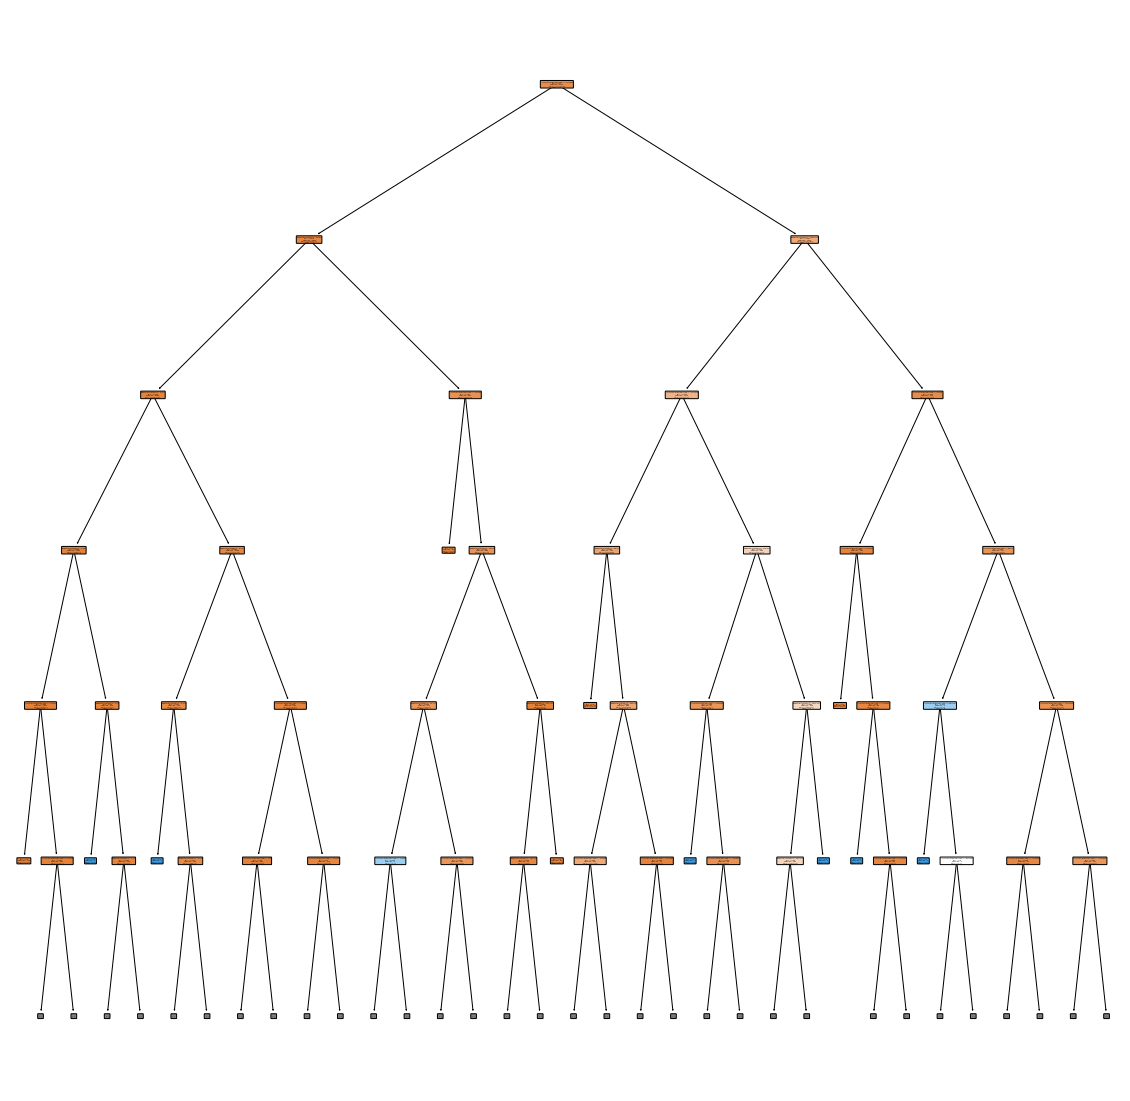

In [297]:
import matplotlib.pyplot as plt

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 20
fig_size[1] = 20
plt.rcParams["figure.figsize"] = fig_size

import numpy as np
sorted = Y.unique()
sorted = np.sort(sorted)
sorted = list(map(str, sorted))

sorted

print(clf.get_n_leaves())

plot = tree.plot_tree(clf, rounded=True, filled=True, class_names=sorted, feature_names=features, max_depth=5)